In [1]:
import pandas as pd
import numpy as np
import os
import sumolib
import random
from tqdm import tqdm
from datetime import datetime

# A. 이동류 매칭

In [2]:
def make_match1():
    '''
    신호 DB에는 매 초마다 이동류정보가 업데이트 된다. 그리고 이 이동류정보를 매 5초마다 불러와서 사용하게 된다.
    '../Data/tables/move/'에는 5초마다의 이동류정보가 저장되어 있다.

    return : 통합된 이동류정보
     - 모든 inter_no(교차로번호)에 대한 A, B링 현시별 이동류정보

    match1을 만드는 데 시간이 소요되므로 한 번 만들어서 저장해두고 저장해둔 것을 쓴다.
    '''
    # [이동류번호] 불러오기 (약 1분의 소요시간)
    path_move = '../Data/tables/move/'
    csv_moves = os.listdir(path_move)
    moves = [pd.read_csv(path_move + csv_move, index_col=0) for csv_move in tqdm(csv_moves)]
    match1 = pd.concat(moves).drop_duplicates().sort_values(by=['inter_no','phas_A','phas_B']).reset_index(drop=True)
    match1.to_csv('../Intermediates/match1.csv')
    return match1

In [3]:
def make_match2(match1):
    '''
    match1을 계층화함.
     - match1의 컬럼 : inter_no, phas_A, phas_B, move_A, move_B
     - match2의 컬럼 : inter_no, phase_no, ring_type, move_no
    '''
    # 계층화 (inter_no, phas_A, phas_B, move_A, move_B) -> ('inter_no', 'phase_no', 'ring_type', 'move_no')
    matchA = match1[['inter_no', 'phas_A', 'move_A']].copy()
    matchA.columns = ['inter_no', 'phase_no', 'move_no']
    matchA['ring_type'] = 'A'
    matchB = match1[['inter_no', 'phas_B', 'move_B']].copy()
    matchB.columns = ['inter_no', 'phase_no', 'move_no']
    matchB['ring_type'] = 'B'
    match2 = pd.concat([matchA, matchB]).drop_duplicates()
    match2 = match2[['inter_no', 'phase_no', 'ring_type', 'move_no']]
    match2 = match2.sort_values(by=list(match2.columns))
    return match2

In [4]:
def make_match3(match2):
    '''
    각 movement들에 방향(진입방향, 진출방향)을 매칭시켜 추가함.
     - match2의 컬럼 : inter_no, phase_no, ring_type, move_no
     - match3의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir

    nema : 
     - 컬럼 : move_no, inc_dir, out_dir
     - 모든 종류의 이동류번호에 대하여 진입방향과 진출방향을 매칭시키는 테이블
     - 이동류번호 : 1 ~ 16, 17, 18, 21
     - 진입, 진출방향(8방위) : 동, 서, 남, 북, 북동, 북서, 남동, 남서
    '''
    # nema 정보 불러오기 및 병합
    nema = pd.read_csv('../Data/tables/nema.csv', encoding='cp949')
    match3 = pd.merge(match2, nema, how='left', on='move_no').drop_duplicates()
    return match3

In [5]:
def make_match4(match3):
    '''
    방위각 정보를 매칭시켜 추가함.
     - match3의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir
     - match4의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir, inc_angle, out_angle

    angle_original : 
     - 컬럼 : inter_no, angle_Aj, angle_Bj (j : 1 ~ 8)
     - 모든 종류의 이동류번호에 대하여 진입방향과 진출방향을 매칭시키는 테이블
     - 이동류번호 : 1 ~ 16, 17, 18, 21
     - 진입, 진출방향(8방위) : 동, 서, 남, 북, 북동, 북서, 남동, 남서
    '''

    # 방위각 정보 불러오기
    dtype_dict = {f'angle_{alph}{j}':'str' for alph in ['A', 'B'] for j in range(1,9)}
    angle_original = pd.read_csv('../Data/tables/angle.csv', index_col=0, dtype = dtype_dict)

    # 계층화
    angle = []
    for i, row in angle_original.iterrows():
        angle_codes = row[[f'angle_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
        new = pd.DataFrame({'inter_no':[row.inter_no] * 16, 'phase_no':list(range(1, 9))*2, 'ring_type':['A'] * 8 + ['B'] * 8, 'angle_code':angle_codes.to_list()})
        angle.append(new)
    angle = pd.concat(angle)
    angle = angle.dropna().reset_index(drop=True)

    # 병합
    six_chars = angle.angle_code.apply(lambda x:len(x)==6)
    angle.loc[six_chars,'inc_angle'] = angle.angle_code.apply(lambda x:x[:3])
    angle.loc[six_chars,'out_angle'] = angle.angle_code.apply(lambda x:x[3:])
    angle = angle.drop('angle_code', axis=1)
    match4 = pd.merge(match3, angle, how='left', left_on=['inter_no', 'phase_no', 'ring_type'],
                    right_on=['inter_no', 'phase_no', 'ring_type']).drop_duplicates()
    return match4

In [6]:
def make_match5(match4):
    '''
    진입엣지id, 진출엣지id, 노드id를 추가함 (주교차로).
     - match4의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir, inc_angle, out_angle
     - match5의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir, inc_angle, out_angle, inc_edge, out_edge, node_id
    
    사용된 데이터 : 
    (1) net
     - 성남시 정자동 부근의 샘플 네트워크
    (2) inter_node
     - 교차로번호와 노드id를 매칭시키는 테이블.
     - parent/child 정보도 포함되어 있음
     - 컬럼 : inter_no, node_id, inter_type
    (3) inter_info
     - 교차로 정보. 여기에서는 위도와 경도가 쓰임.
     - 컬럼 : inter_no, inter_name, inter_lat, inter_lon, group_no, main_phase_no

    진입엣지id, 진출엣지id를 얻는 과정 :
     - match5 = match4.copy()의 각 열을 순회하면서 아래 과정을 반복함.
     * 진입에 대해서만 서술하겠지만 진출도 마찬가지로 설명될 수 있음
     - 해당 행의 교차로정보로부터 노드ID를 얻어내고, 해당 노드에 대한 모든 진출엣지id를 inc_edges에 저장.
     * inc_edge(진입엣지) : incoming edge, out_edge(진출엣지) : outgoing_edge
     - inc_edges의 모든 진입엣지에 대하여 진입방향(inc_dires, 2차원 단위벡터)을 얻어냄.
     - 해당 행의 진입각으로부터 그에 대응되는 진입각방향(단위벡터)를 얻어냄.
     - 주어진 진입각방향에 대하여 내적이 가장 작은 진입방향에 대한 진입엣지를 inc_edge_id로 지정함.
    '''

    # 네트워크 불러오기 
    net = sumolib.net.readNet('../Data/networks/sn.net.xml')
    # 교차로-노드 매칭 정보 불러오기
    inter_node = pd.read_csv('../Data/tables/inter_node.csv', index_col=0)
    # 교차로정보(위, 경도) 불러오기
    inter_info = pd.read_csv('../Data/tables/inter_info.csv', index_col=0)

    # parent node만 가져옴.
    inter_node1 = inter_node[inter_node.inter_type == 'parent'].drop('inter_type', axis=1)
    inter_info1 = inter_info[['inter_no', 'inter_lat', 'inter_lon']]
    inter = pd.merge(inter_node1, inter_info1, how='left', left_on=['inter_no'],
                    right_on=['inter_no']).drop_duplicates()

    inter2node = dict(zip(inter['inter_no'], inter['node_id']))

    match5 = match4.copy()
    # 진입진출ID 매칭
    for index, row in match5.iterrows():
        node_id = inter2node[row.inter_no]
        node = net.getNode(node_id)
        # 교차로의 모든 (from / to) edges
        inc_edges = [edge for edge in node.getIncoming() if edge.getFunction() == ''] # incoming edges
        out_edges = [edge for edge in node.getOutgoing() if edge.getFunction() == ''] # outgoing edges
        # 교차로의 모든 (from / to) directions
        inc_dirs = []
        for inc_edge in inc_edges:
            start = inc_edge.getShape()[-2]
            end = inc_edge.getShape()[-1]
            inc_dir = np.array(end) - np.array(start)
            inc_dir = inc_dir / (inc_dir ** 2).sum() ** 0.5
            inc_dirs.append(inc_dir)
        out_dirs = []
        for out_edge in out_edges:
            start = out_edge.getShape()[0]
            end = out_edge.getShape()[1]
            out_dir = np.array(end) - np.array(start)
            out_dir = out_dir / (out_dir ** 2).sum() ** 0.5
            out_dirs.append(out_dir)
        # 진입각, 진출각 불러오기
        if not pd.isna(row.inc_angle):
            inc_angle = int(row.inc_angle)
            out_angle = int(row.out_angle)
            # 방위각을 일반각으로 가공, 라디안 변환, 단위벡터로 변환
            inc_angle = (-90 - inc_angle) % 360
            inc_angle = inc_angle * np.pi / 180.
            inc_dir_true = np.array([np.cos(inc_angle), np.sin(inc_angle)])
            out_angle = (90 - out_angle) % 360
            out_angle = out_angle * np.pi / 180.
            out_dir_true = np.array([np.cos(out_angle), np.sin(out_angle)])
            # 매칭 엣지 반환
            inc_index = np.array([np.dot(inc_dir, inc_dir_true) for inc_dir in inc_dirs]).argmax()
            out_index = np.array([np.dot(out_dir, out_dir_true) for out_dir in out_dirs]).argmax()
            inc_edge_id = inc_edges[inc_index].getID()
            out_edge_id = out_edges[out_index].getID()
            match5.at[index, 'inc_edge'] = inc_edge_id
            match5.at[index, 'out_edge'] = out_edge_id
    match5['node_id'] = match5['inter_no'].map(inter2node)
    match5 = match5.sort_values(by=['inter_no','phase_no','ring_type']).reset_index(drop=True)
    return match5

In [7]:
def make_match6(match5):
    '''
    진입엣지id, 진출엣지id, 노드id를 추가함 (부교차로).
     - match6의 컬럼 : inter_no, phase_no, ring_type, move_no, inc_dir, out_dir, inc_angle, out_angle, inc_edge, out_edge, node_id
    
    사용된 데이터 : 
    (1) inter_node
     - 교차로번호와 노드id를 매칭시키는 테이블.
     - parent/child 정보도 포함되어 있음
     - 컬럼 : inter_no, node_id, inter_type
    (2) uturn (유턴정보)
     - 컬럼 : parent_id, child_id, direction, condition, inc_edge, out_edge
     - parent_id, child_id : 주교차로id, 유턴교차로id
     - direction : 주교차로에 대한 유턴노드의 상대적인 위치(방향)
     - condition : 좌회전시, 직진시, 직좌시, 보행신호시 중 하나
     - inc_edge, out_edge : 유턴에 대한 진입진출엣지
    (3) coord (연동교차로정보)
     - 컬럼 : parent_id, child_id, phase_no, ring_type, inc_edge, out_edge
     - parent_id, child_id : 주교차로id, 연동교차로id
     - 나머지 컬럼 : 각 (현시, 링)별 진입진출엣지

    설명 :
     - match5는 주교차로에 대해서만 진입엣지id, 진출엣지id, 노드id를 추가했었음.
       여기에서 uturn, coord를 사용해서 부교차로들(유턴교차로, 연동교차로)에 대해서도 해당 값들을 부여함.
    유턴교차로 :
     - directions를 정북기준 시계방향의 8방위로 정함.
        - 이를 통해 진입방향이 주어진 경우에 좌회전, 직진, 보행 등에 대한 (진입방향, 진출방향)을 얻어낼 수 있음.
        - 예) 진입방향(direction)이 '북'일 때, 
        - 직진 : (북, 남)
            * 남 : directions[(ind + 4) % len(directions)]
        - 좌회전 : (북, 동)
            * 동 : directions[(ind + 2) % len(directions)]
        - 보행 : (서, 동)
            * 서 : directions[(ind - 2) % len(directions)]
     - uturn의 각 행을 순회하면서 아래 과정을 반복함
        - match5에서 parent_id에 해당하는 행들을 가져옴(cmatch).
        - condition 별로 진입방향, 진출방향A, 진출방향B 정함.
            - 상술한 directions를 활용하여 정함.
        - (진입방향, 진출방향A, 진출방향B)을 고려하여 (현시, 링) 별로 진입엣지id, 진출엣지id를 정함.
            - ex) cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
     - 순회하면서 만든 cmatch를 cmatchs라는 리스트에 저장함.

    연동교차로 :
     - 연동교차로의 경우 coord에 (현시, 링)별 진입엣지ID, 진출엣지ID가 명시되어 있음.
     - 'inc_dir', 'out_dir', 'inc_angle','out_angle'와 같은 열들은 np.nan을 지정해놓음.
     - 이 열들은, 사실상 다음 스텝부터는 사용되지 않는 열들이기 때문에 np.nan으로 지정해놓아도 문제없음.

    match6 :
     - 이렇게 얻은 match5, cmatchs, coord를 모두 pd.concat하여 match6을 얻어냄.
    '''

    inter_node = pd.read_csv('../Data/tables/inter_node.csv', index_col=0)
    node2inter = dict(zip(inter_node['node_id'], inter_node['inter_no']))

    uturn = pd.read_csv('../Data/tables/child_uturn.csv')
    coord = pd.read_csv('../Data/tables/child_coord.csv')
    child_ids = inter_node[inter_node.inter_type=='child'].node_id.unique()
    ch2pa = {} # child to parent
    for child_id in child_ids:
        parent_no = inter_node[inter_node.node_id==child_id].inter_no.iloc[0]
        sub_inter_node = inter_node[inter_node.inter_no==parent_no]
        ch2pa[child_id] = sub_inter_node[sub_inter_node.inter_type=='parent'].iloc[0].node_id
    directions = ['북', '북동', '동', '남동', '남', '남서', '서', '북서'] # 정북기준 시계방향으로 8방향

    # 각 uturn node에 대하여 (inc_edge_id, out_edge_id) 부여
    cmatches = []
    for _, row in uturn.iterrows():
        child_id = row.child_id
        parent_id = row.parent_id
        direction = row.direction
        condition = row.condition
        inc_edge_id = row.inc_edge
        out_edge_id = row.out_edge
        # match5에서 parent_id에 해당하는 행들을 가져옴
        cmatch = match5.copy()[match5.node_id==parent_id] # match dataframe for a child node
        cmatch = cmatch.sort_values(by=['phase_no', 'ring_type']).reset_index(drop=True)
        cmatch['node_id'] = child_id
        cmatch[['inc_edge', 'out_edge']] = np.nan

        # condition 별로 inc_dire, out_dire_A, out_dire_B를 정함
        ind = directions.index(direction)
        if condition == "좌회전시":
            inc_dire = direction
            out_dire_A = out_dire_B = directions[(ind + 2) % len(directions)]
        elif condition == "직진시":
            inc_dire = direction
            out_dire_A = out_dire_B = directions[(ind + 4) % len(directions)]
        elif condition == "보행신호시":
            inc_dire = directions[(ind + 2) % len(directions)]
            out_dire_A = directions[(ind - 2) % len(directions)]
            out_dire_B = directions[(ind - 2) % len(directions)]

        # (inc_dire, out_dire_A, out_dire_B) 별로 inc_edge_id, out_edge_id를 정함
        if condition == '보행신호시':
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
            # 이동류번호가 17(보행신호)이면서 유턴노드방향으로 가는 신호가 없으면 (inc_edge_id, out_edge_id)를 부여한다.
            cmatch.loc[(cmatch.move_no==17) & (cmatch.out_dir!=direction), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
        else: # '직진시', '좌회전시'
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
            cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), ['inc_edge', 'out_edge']] = [inc_edge_id, out_edge_id]
        # 유턴신호의 이동류번호를 19로 부여한다.
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_A), 'move_no'] = 19
        cmatch.loc[(cmatch.inc_dir==inc_dire) & (cmatch.out_dir==out_dire_B), 'move_no'] = 19
        cmatches.append(cmatch)

    # 각 coordination node에 대하여 (inc_edge_id, out_edge_id) 부여
    coord['inter_no'] = coord['parent_id'].map(node2inter)
    coord = coord.rename(columns={'child_id':'node_id'})
    coord[['inc_dir', 'out_dir', 'inc_angle','out_angle']] = np.nan
    coord['move_no'] = 20
    coord = coord[['inter_no', 'phase_no', 'ring_type', 'move_no', 'inc_dir', 'out_dir', 'inc_angle','out_angle', 'inc_edge', 'out_edge', 'node_id']]
    
    # display(coord)
    cmatches = pd.concat(cmatches)
    match6 = pd.concat([match5, cmatches, coord]).drop_duplicates().sort_values(by=['inter_no', 'node_id', 'phase_no', 'ring_type'])
    match6.to_csv('../Intermediates/match6.csv')
    return match6

In [8]:
def make_matching(match6):
    '''
    이동류 매칭 : 각 교차로에 대하여, 가능한 모든 이동류 (1~18, 21)에 대한 진입·진출엣지ID를 지정한다.
    모든 이동류에 대해 지정하므로, 시차제시 이전과 다른 이동류가 등장하더라도 항상 진입·진출 엣지 ID를 지정할 수 있다.    
     - matching의 컬럼 : inter_no, move_no, inc_dir, out_dir, inc_edge, out_edge, node_id
    
    설명 : 
     - 필요한 리스트, 딕셔너리 등을 정의
        (1) 가능한 (진입방향, 진출방향) 목록 [리스트]
        (2) 각 교차로별 방향 목록 : pdires (possible directions) [딕셔너리]
        (3) 각 (교차로, 진입방향) 별 진입id 목록 : inc2id (incoming direction to incoming edge_id) [딕셔너리]
        (4) 각 (교차로, 진출방향) 별 진출id 목록 : out2id (outgoing direction to outgoing edge_id) [딕셔너리]
        (5) 각 교차로별 가능한 (진입방향, 진출방향) 목록 : pflow (possible flows) [딕셔너리]
     - matching은 빈 리스트로 지정.
     - 모든 노드id에 대하여 다음 과정을 반복
     - 해당 노드id에 대한 모든 가능한 (진입방향, 진출방향)에 대하여 다음 과정을 반복
     - (노드id, 진입방향)으로부터 진입엣지id를 얻어냄. 마찬가지로 진출엣지id도 얻어냄
     - 얻어낸 정보를 바탕으로 한 행(new_row)을 만들고 이것을 matching에 append
     '''

    match7 = match6.copy()
    match7 = match7[['inter_no', 'move_no', 'inc_dir', 'out_dir', 'inc_edge', 'out_edge', 'node_id']]
    inter_node = pd.read_csv('../Data/tables/inter_node.csv', index_col=0)
    nema = pd.read_csv('../Data/tables/nema.csv', encoding='cp949')

    parent_ids = sorted(inter_node[inter_node.inter_type=='parent'].node_id.unique())
    child_ids = sorted(inter_node[inter_node.inter_type=='child'].node_id.unique())

    # (1) 가능한 (진입방향, 진출방향) 목록 
    flows = nema.dropna().apply(lambda row: (row['inc_dir'], row['out_dir']), axis=1).tolist()
    # (2) 각 교차로별 방향 목록 : pdires (possible directions)
    pdires = {}
    for node_id in parent_ids:
        dires = match7[match7.node_id == node_id][['inc_dir','out_dir']].values.flatten()
        dires = {dire for dire in dires if type(dire)==str}
        pdires[node_id] = dires
    # (3) 각 (교차로, 진입방향) 별 진입id 목록 : inc2id (incoming direction to incoming edge_id)
    inc2id = {}
    for node_id in parent_ids:
        for inc_dir in pdires[node_id]:
            df = match7[(match7.node_id==node_id) & (match7.inc_dir==inc_dir)]
            inc2id[(node_id, inc_dir)] = df.inc_edge.iloc[0]
    # (4) 각 (교차로, 진출방향) 별 진출id 목록 : out2id (outgoing direction to outgoing edge_id)
    out2id = {}
    for node_id in parent_ids:
        for out_dir in pdires[node_id]:
            df = match7[(match7.node_id==node_id) & (match7.out_dir==out_dir)]
            out2id[(node_id, out_dir)] = df.out_edge.iloc[0]
    # (5) 각 교차로별 가능한 (진입방향, 진출방향) 목록 : pflow (possible flows)
    pflow = {}
    for node_id in parent_ids:
        pflow[node_id] = [flow for flow in flows if set(flow).issubset(pdires[node_id])]
    # (6) 가능한 이동류에 대하여 진입id, 진출id 배정 : matching
    node2inter = dict(zip(match7['node_id'], match7['inter_no']))
    dires_right = ['북', '서', '남', '동', '북'] # ex (북, 서), (서, 남) 등은 우회전 flow
    matching = []
    for node_id in parent_ids:
        inter_no = node2inter[node_id]
        # 좌회전과 직진(1 ~ 16)
        for (inc_dir, out_dir) in pflow[node_id]:
            move_no = nema[(nema.inc_dir==inc_dir) & (nema.out_dir==out_dir)].move_no.iloc[0]
            inc_edge = inc2id[(node_id, inc_dir)]
            out_edge = out2id[(node_id, out_dir)]
            new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[move_no],
                                    'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                    'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
            matching.append(new_row)
        # 보행신호(17), 전적색(18)
        new_row = pd.DataFrame({'inter_no':[inter_no] * 2, 'move_no':[17, 18],
                                'inc_dir':[None]*2, 'out_dir':[None]*2,
                                'inc_edge':[None]*2, 'out_edge':[None]*2, 'node_id':[node_id]*2})
        matching.append(new_row)
        # 신호우회전(21)
        for d in range(len(dires_right)-1):
            inc_dir = dires_right[d]
            out_dir = dires_right[d+1]
            if {inc_dir, out_dir}.issubset(pdires[node_id]):
                inc_edge = inc2id[(node_id, inc_dir)]
                out_edge = out2id[(node_id, out_dir)]
                new_row = pd.DataFrame({'inter_no':[inter_no], 'move_no':[21],
                                        'inc_dir':[inc_dir], 'out_dir':[out_dir],
                                        'inc_edge':[inc_edge], 'out_edge':[out_edge], 'node_id':[node_id]})
                matching.append(new_row)
    matching.append(match7[match7.node_id.isin(child_ids)])
    matching = pd.concat(matching)
    matching = matching.dropna().sort_values(by=['inter_no', 'node_id', 'move_no']).reset_index(drop=True)
    matching['move_no'] = matching['move_no'].astype(int)
    matching.to_csv('../Intermediates/matching.csv')
    return matching

In [9]:
match1 = pd.read_csv('../Intermediates/match1.csv', index_col=0)
match2 = make_match2(match1)
match3 = make_match3(match2)
match4 = make_match4(match3)
match5 = make_match5(match4)
match6 = make_match6(match5)
matching = make_matching(match6)

# B. 5초 간격으로 이동류번호 수집

In [10]:
# 5초 단위로 이동류번호 저장 및 신호이력에서 유닉스시각 가져와서 표시, 한시간동안의 데이터만 보관
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fsecs = range(midnight, next_day, 5) # fsecs : unix time by Five SECondS
fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS

In [11]:
def save_movement():
    # time2move = dict(zip(fsecs,moves)) # move : 어느 순간의 이동류정보
    history = pd.read_csv('../Data/tables/history.csv', index_col=0)

    time2movement = {} # movement : 어느 순간의, 그 순간으로부터 한시간 동안의 (교차로번호 + 현시별이동류번호 + 시작시간)
    # - 아래 절차를 5초마다 반복
    for fsec in tqdm(fsecs): # fsec : unix time by Five SECond
        # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
        # move = time2move[fsec]
        move = pd.read_csv(f'../Data/tables/move/move_{fsec}.csv', index_col=0)
        # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로변호, 종료유닉스타임)만 수집 : B
        recent_histories = [group.iloc[-1:] for _, group in history[history['end_unix'] < fsec].groupby('inter_no')] # 교차로별로 유닉스시간이 최대인 행들
        if not recent_histories:
            rhistory = pd.DataFrame({'inter_no':[], 'end_unix':[]}) # recent history
        else:
            rhistory = pd.concat(recent_histories)
        recent_unix = rhistory[['inter_no', 'end_unix']]
        # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
        move = pd.merge(move, recent_unix, how='left', on='inter_no')
        move['end_unix'] = move['end_unix'].fillna(0).astype(int)
        move = move.drop_duplicates()
        # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
        move = move.rename(columns = {'end_unix':'start_unix'})
        # 5. 이동류 이력정보 READ
        #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
        try:
            if isinstance(movement, pd.DataFrame): # movement가 존재할 경우 그걸 그대로 씀.
                pass
            else: 
                movement = pd.DataFrame()
        except NameError: # movement가 존재하지 않는 경우 생성
            movement = pd.DataFrame()
        # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
        movement = pd.concat([movement, move])
        # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
        movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
        # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - 3600을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
        movement = movement[movement.start_unix > fsec - 3600]
        movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)

        time2movement[fsec] = movement
        movement.to_csv(f'../Intermediates/movement/movement_{fsec}.csv')
# save_movement()

# C. 5분 간격으로 신호이력 수집 및 통합테이블 생성

In [12]:
m = 105
midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
fmins = range(midnight, next_day, 300)

# 현재시각
present_time = fmins[m]

plan = pd.read_csv('../Data/tables/plan.csv', index_col=0)
history = pd.read_csv('../Data/tables/history.csv', index_col=0)

In [13]:
def make_splits(plan):
    # split, isplit : A,B 분리 혹은 통합시 사용될 수 있는 딕셔너리 
    splits = {} # splits maps (inter_no, start_hour, start_minute) to split 
    for i, row in plan.iterrows():
        inter_no = row.inter_no
        start_hour = row.start_hour
        start_minute = row.start_minute
        cycle = row.cycle
        cums_A = row[[f'dura_A{j}' for j in range(1,9)]].cumsum()
        cums_B = row[[f'dura_B{j}' for j in range(1,9)]].cumsum()
        splits[(inter_no, start_hour, start_minute)] = {} # split maps (phas_A, phas_B) to k
        k = 0
        for t in range(cycle):
            new_phas_A = len(cums_A[cums_A < t]) + 1
            new_phas_B = len(cums_B[cums_B < t]) + 1
            if k == 0 or ((new_phas_A, new_phas_B) != (phas_A, phas_B)):
                k += 1
            phas_A = new_phas_A
            phas_B = new_phas_B
            splits[(inter_no, start_hour, start_minute)][(phas_A, phas_B)] = k

    isplits = {} # the inverse of splits
    for i in splits:
        isplits[i] = {splits[i][k]:k for k in splits[i]} # isplit maps k to (phas_A, phas_B)
    return splits, isplits
splits, isplits = make_splits(plan)

def make_timetable(plan):
    # timetable
    timetable = plan[['start_hour', 'start_minute']].drop_duplicates()
    timetable['start_seconds'] = midnight + timetable['start_hour'] * 3600 + timetable['start_minute'] * 60
    return timetable
timetable = make_timetable(plan)

# inter2node
inter_node = pd.read_csv('../Data/tables/inter_node.csv', index_col=0)
inter_node = inter_node[inter_node.inter_type=='parent']
inter2node = dict(zip(inter_node['inter_no'], inter_node['node_id']))

In [14]:
def calculate_DS(rhist, curr_unix, hours):
    if list(hours[hours <= curr_unix]):
        ghour_lt_curr_unix = hours[hours <= curr_unix].max() # the greatest hour less than or equal to curr_unix
    else:
        ghour_lt_curr_unix = midnight
    start_unixes = rhist.start_unix.unique()
    start_unixes_lt_ghour = np.sort(start_unixes[start_unixes < ghour_lt_curr_unix]) # start unixes less than ghour_lt_curr_unix
    # 기준유닉스(base_unix) : curr_unix보다 작은 hour 중에서 가장 큰 값으로부터 다섯 번째로 작은 start_unix
    if len(start_unixes_lt_ghour) > 5:
        base_unix = start_unixes_lt_ghour[-5]
    # start_unixes_lt_ghour의 길이가 5 미만일 경우에는 맨 앞 start_unix로 base_unix를 지정
    else:
        base_unix = rhist.start_unix.min()
    D_n = curr_unix - base_unix
    S_n_durs = rhist[(rhist.start_unix > base_unix) & (rhist.start_unix <= curr_unix)] \
        [[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]]
    S_n = S_n_durs.values.sum() // 2
    return D_n, S_n

In [15]:
def make_rhistory(history, present_time):
    # 1. 조회시점의 유닉스 타임 이전의 신호이력 수집
    rhistory = history.copy() # recent history
    rhistory = rhistory[(rhistory.end_unix <= present_time) & (rhistory.end_unix > present_time - 9000)] # 두 시간 반 전부터 현재까지의 신호이력을 가져옴. 9000 = 3600 * 2.5
    # 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
    # - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
    for i, row in rhistory.iterrows():
        inter_no = row.inter_no
        end_unix = row.end_unix
        elapsed_time = row[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2 # 현시시간 합
        # 이전 유닉스 존재하지 않음 : 현시시간 합의 차
        start_unix = end_unix - elapsed_time
        pre_rows = history[:i] # previous rows
        if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
            pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
            # 이전 유닉스 존재, abs < 10 : 이전 유닉스
            if abs(pre_unix - start_unix) < 10:
                start_unix = pre_unix
            # 이전 유닉스 존재, abs >=10 : 현시시간 합의 차
            else:
                pass
        rhistory.loc[i, 'start_unix'] = start_unix 
    rhistory[rhistory.isna()] = 0
    rhistory['start_unix'] = rhistory['start_unix'].astype(int)
    rhistory = rhistory[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle']]
    return rhistory

rhistory = make_rhistory(history, present_time)

In [16]:
def process(rhistory, hours):
    rhists = []
    for inter_no in sorted(rhistory.inter_no.unique()):
        rhist = rhistory.copy()[rhistory.inter_no==inter_no]
        rhist = rhist.drop_duplicates(subset=['start_unix']).reset_index(drop=True)

        # D_n 및 S_n 값 정의
        rhist['D_n'] = 0 # D_n : 시간차이
        rhist['S_n'] = 0 # S_n : 현시시간합
        for n in range(len(rhist)):
            curr_unix = rhist.iloc[n].start_unix # current start_unix
            rhist.loc[n, ['D_n', 'S_n']] = calculate_DS(rhist, curr_unix, hours)

        # 이전시각, 현재시각
        prev_unix = rhist.loc[0, 'start_unix'] # previous start_unix
        curr_unix = rhist.loc[1, 'start_unix'] # current start_unix

        # rhist의 마지막 행에 도달할 때까지 반복
        while True:
            n = rhist[rhist.start_unix==curr_unix].index[0]
            cycle = rhist.loc[n, 'cycle']
            D_n = rhist.loc[n, 'D_n']
            S_n = rhist.loc[n, 'S_n']
            # 참값인 경우
            if (abs(D_n - S_n) <= 5):
                pass
            # 참값이 아닌 경우
            else:
                # 2-1-1. 결측치 처리 : 인접한 두 start_unix의 차이가 계획된 주기의 두 배보다 크면 결측이 일어났다고 판단, 신호계획의 현시시간으로 "대체"
                if curr_unix - prev_unix >= 2 * cycle:
                    # prev_unix를 계획된 주기만큼 늘려가면서 한 행씩 채워나간다.
                    # (curr_unix와의 차이가 계획된 주기보다 작거나 같아질 때까지)
                    while curr_unix - prev_unix > cycle:
                        prev_unix += cycle
                        # 신호 계획(prow) 불러오기
                        start_seconds = np.array(timetable.start_seconds)
                        idx = (start_seconds <= prev_unix).sum() - 1
                        start_hour = timetable.iloc[idx].start_hour
                        start_minute = timetable.iloc[idx].start_minute
                        prow = plan.copy()[(plan.inter_no==inter_no) & (plan.start_hour==start_hour) & (plan.start_minute==start_minute)] # planned row
                        # prow에서 필요한 부분을 rhist에 추가
                        prow['start_unix'] = prev_unix
                        prow = prow.drop(['start_hour', 'start_minute', 'offset'], axis=1)
                        cycle = prow.iloc[0].cycle
                        rhist = pd.concat([rhist, prow])
                        rhist = rhist.sort_values(by='start_unix').reset_index(drop=True)
                        n += 1

                # 2-1-2. 이상치 처리 : 비율에 따라 해당 행을 "삭제"(R_n <= 0.5) 또는 "조정"(R_n > 0.5)한다
                R_n = (curr_unix - prev_unix) / cycle # R_n : 비율
                # R_n이 0.5보다 작거나 같으면 해당 행을 삭제
                if R_n <= 0.5:
                    rhist = rhist.drop(index=n).reset_index(drop=True)
                    if n >= rhist.index[-1]:
                        break
                    # 행삭제에 따른 curr_unix, R_n 재정의
                    curr_unix = rhist.loc[n, 'start_unix']
                    R_n = (curr_unix - prev_unix) / cycle # R_n : 비율

                # R_n이 0.5보다 크면 해당 행 조정 (비율을 유지한 채로 현시시간 대체)
                if R_n > 0.5:
                    # 신호 계획(prow) 불러오기
                    start_seconds = np.array(timetable.start_seconds)
                    idx = (start_seconds <= curr_unix).sum() - 1
                    start_hour = timetable.iloc[idx].start_hour
                    start_minute = timetable.iloc[idx].start_minute
                    prow = plan[(plan.inter_no==inter_no) & (plan.start_hour==start_hour) & (plan.start_minute==start_minute)] # planned row
                    # 조정된 현시시간 (prow에 R_n을 곱하고 정수로 바꿈)
                    adjusted_dur = prow.copy()[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] * R_n
                    int_parts = adjusted_dur.iloc[0].apply(lambda x: int(x))
                    frac_parts = adjusted_dur.iloc[0] - int_parts
                    difference = round(adjusted_dur.iloc[0].sum()) - int_parts.sum()
                    for _ in range(difference): # 소수 부분이 가장 큰 상위 'difference'개의 값에 대해 올림 처리
                        max_frac_index = frac_parts.idxmax()
                        int_parts[max_frac_index] += 1
                        frac_parts[max_frac_index] = 0  # 이미 처리된 항목은 0으로 설정
                    # rhist에 조정된 현시시간을 반영
                    rhist.loc[n, [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] = int_parts.values
                    rhist.loc[n, 'cycle'] = int_parts.sum().sum() // 2

            if n >= rhist.index[-1]:
                break
            prev_unix = curr_unix
            curr_unix = rhist.loc[n+1, 'start_unix']

        # 생략해도 무방할 코드
        rhist = rhist.reset_index(drop=True)
        rhist = rhist.sort_values(by=['start_unix'])

        # D_n 및 S_n 값 재정의
        for n in range(len(rhist)):
            curr_unix = rhist.iloc[n].start_unix # current start_unix
            rhist.loc[n, ['D_n', 'S_n']] = calculate_DS(rhist, curr_unix, hours)
        rhists.append(rhist)
    rhists = pd.concat(rhists).sort_values(by=['start_unix','inter_no'])
    rhists = rhists[rhists.start_unix >= present_time - 3600]
    rhists = rhists.drop(columns=['D_n', 'S_n'])
    return rhists

In [17]:
def make_rhists(rhistory, present_time):
    # 1. 조회시점의 유닉스 타임 이전의 신호이력 수집
    rhistory = history.copy() # recent history
    rhistory = rhistory[(rhistory.end_unix <= present_time) & (rhistory.end_unix > present_time - 9000)] # 두 시간 반 전부터 현재까지의 신호이력을 가져옴. 9000 = 3600 * 2.5
    # 2. 시작 유닉스 타임컬럼 생성 후 종류 유닉스 타임에서 현시별 현시기간 컬럼의 합을 뺀 값으로 입력
    # - 현시시간의 합을 뺀 시간의 +- 10초 이내에 이전 주기정보가 존재하면 그 유닉스 시간을 시작 유닉스시간 값으로 하고, 존재하지 않으면 현시시간의 합을 뺀 유닉스 시간을 시작 유닉스 시간으로 지정
    for i, row in rhistory.iterrows():
        inter_no = row.inter_no
        end_unix = row.end_unix
        elapsed_time = row[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2 # 현시시간 합
        # 이전 유닉스 존재하지 않음 : 현시시간 합의 차
        start_unix = end_unix - elapsed_time
        pre_rows = history[:i] # previous rows
        if inter_no in pre_rows.inter_no.unique(): # 이전 유닉스 존재
            pre_unix = pre_rows[pre_rows.inter_no == inter_no]['end_unix'].iloc[-1] # previous unix time
            # 이전 유닉스 존재, abs < 10 : 이전 유닉스
            if abs(pre_unix - start_unix) < 10:
                start_unix = pre_unix
            # 이전 유닉스 존재, abs >=10 : 현시시간 합의 차
            else:
                pass
        rhistory.loc[i, 'start_unix'] = start_unix 
    rhistory[rhistory.isna()] = 0
    rhistory['start_unix'] = rhistory['start_unix'].astype(int)
    rhistory = rhistory[['inter_no', 'start_unix'] + [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)] + ['cycle']]

    # 2-1. 참값 판단 프로세스
    hours = np.array(range(midnight - 7200, next_day + 1, 3600)) # 정각에 해당하는 시각들 목록
    rhists = process(rhistory, hours)
    return rhists
rhists = make_rhists(rhistory, present_time)

In [18]:
def make_hrhists(rhists, isplits, timetable):
    # 계층화된 형태로 변환
    hrhists = [] # hierarchied recent history
    for i, row in rhists.iterrows():
        inter_no = row.inter_no
        start_unix = row.start_unix

        ind = (timetable['start_seconds'] <= row.start_unix).sum() - 1
        start_hour = timetable.iloc[ind].start_hour
        start_minute = timetable.iloc[ind].start_minute
        isplit = isplits[(inter_no, start_hour, start_minute)]
        phas_As = [isplit[j][0] for j in isplit.keys()]
        phas_Bs = [isplit[j][1] for j in isplit.keys()]
        durs_A = row[[f'dura_A{j}' for j in range(1,9)]]
        durs_B = row[[f'dura_B{j}' for j in range(1,9)]]
        durations = []
        for j in range(1, len(isplit)+1):
            ja = isplit[j][0]
            jb = isplit[j][1]
            if ja == jb:
                durations.append(min(durs_A[ja-1], durs_B[jb-1]))
            else:
                durations.append(abs(durs_A[ja-1] - durs_B[ja-1]))
        new_rows = pd.DataFrame({'inter_no':[inter_no] * len(durations), 'start_unix':[start_unix] * len(durations),
                                'phas_A':phas_As, 'phas_B':phas_Bs, 'duration':durations})
        hrhists.append(new_rows)
    hrhists = pd.concat(hrhists)
    hrhists = hrhists.sort_values(by = ['start_unix', 'inter_no', 'phas_A', 'phas_B']).reset_index(drop=True)
    return hrhists
hrhists = make_hrhists(rhists, isplits, timetable)

In [19]:
def make_movements():
    movements_path = '../Intermediates/movement/'
    movements_list = [pd.read_csv(movements_path + file, index_col=0) for file in tqdm(os.listdir(movements_path))]
    movements = pd.concat(movements_list)
    movements = movements.drop(columns=['start_unix'])
    movements = movements.drop_duplicates()
    movements = movements.sort_values(by=['inter_no', 'phas_A', 'phas_B'])
    movements = movements.reset_index(drop=True)
    movements.to_csv('../Intermediates/movements.csv')
    return movements
movements = pd.read_csv('../Intermediates/movements.csv')

In [20]:
def update_movement(hrhists, movement, movements):
    # 중복을 제거하고 (inter_no, start_unix) 쌍을 만듭니다.
    hrhists_inter_unix = set(hrhists[['inter_no', 'start_unix']].drop_duplicates().itertuples(index=False, name=None))
    movement_inter_unix = set(movement[['inter_no', 'start_unix']].drop_duplicates().itertuples(index=False, name=None))

    # hrhists에는 있지만 movement에는 없는 (inter_no, start_unix) 쌍을 찾습니다.
    missing_in_movement = hrhists_inter_unix - movement_inter_unix

    # 새로운 행들을 생성합니다.
    new_rows = []
    if missing_in_movement:
        for inter_no, start_unix in missing_in_movement:
            # movements에서 해당 inter_no의 데이터를 찾습니다.
            new_row = movements[movements['inter_no'] == inter_no].copy()
            # start_unix 값을 설정합니다.
            new_row['start_unix'] = start_unix
            new_rows.append(new_row)

        # 새로운 데이터프레임을 생성하고 기존 movement 데이터프레임과 합칩니다.
        new_movement = pd.concat(new_rows, ignore_index=True)
        movement_updated = pd.concat([movement, new_movement], ignore_index=True)
    else:
        movement_updated = movement
    return movement_updated
movement = pd.read_csv(f'../Intermediates/movement/movement_{present_time}.csv', index_col=0)
movement_updated = update_movement(hrhists, movement, movements)

In [21]:
def make_histid(present_time, movedur, inter2node):
    # 이동류 매칭 테이블에서 진입id, 진출id를 가져와서 붙임.
    for i, row in movedur.iterrows():
        inter_no = row.inter_no
        start_unix = row.start_unix
        # incoming and outgoing edges A
        move_A = row.move_A
        if move_A in [17, 18]:
            inc_edge_A = np.nan
            out_edge_A = np.nan
        else:
            match_A = matching[(matching.inter_no == inter_no) & (matching.move_no == move_A)].iloc[0]
            inc_edge_A = match_A.inc_edge
            out_edge_A = match_A.out_edge
        movedur.loc[i, ['inc_edge_A', 'out_edge_A']] = [inc_edge_A, out_edge_A]
        # incoming and outgoing edges B
        move_B = row.move_B
        if move_B in [17, 18]:
            inc_edge_B = np.nan
            out_edge_B = np.nan
        else:
            match_B = matching[(matching.inter_no == inter_no) & (matching.move_no == move_B)].iloc[0]
            inc_edge_B = match_B.inc_edge
            out_edge_B = match_B.out_edge
        movedur.loc[i, ['inc_edge_B', 'out_edge_B']] = [inc_edge_B, out_edge_B]

    # 이동류 컬럼 제거
    movedur = movedur.drop(['move_A', 'move_B'], axis=1)

    histid = movedur.copy() # history with edge ids (incoming and outgoing edge ids)
    histid['node_id'] = histid['inter_no'].map(inter2node)
    histid = histid[['inter_no', 'node_id', 'start_unix', 'phas_A', 'phas_B', 'duration', 'inc_edge_A', 'out_edge_A', 'inc_edge_B', 'out_edge_B']]
    histid_start = present_time - 1200
    histid = histid[histid.start_unix > histid_start]
    return histid
# movedur
movedur = pd.merge(movement_updated, hrhists, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B']) # movements and durations
movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]
histid = make_histid(present_time, movedur, inter2node)

In [22]:
def preprocess(m):
   '''
   통합테이블(histid)를 만드는 함수

   input : m
    - m ranges from 0 to 287, but 0 makes an error where 288 = 86400//300
    - present_time = fmins[m] : 현재시점

   output : histid (통합테이블, HISTory with edge_IDs)
    - 컬럼 : inter_no, node_id, start_unix, phas_A, phas_B, duration, inc_edge_A, out_edge_A, inc_edge_B, out_edge_B

   주요 데이터, 중간산출물 및 결과물 :
   # 데이터
    - history : 신호이력 (inter_no, end_unix, dura_Aj, dura_Bj, cycle, offset)
    - plan : 신호계획 (inter_no, start_hour, start_minute, dura_Aj, dura_Bj cycle, offset)
   # 중간산출물
    - rhists (recent history)
       - history에서 현재 시각 이전의 데이터를 가져옴.
       - end_unix를 start_unix로 변환
       - 참값판단 프로세스(결측·이상치 처리)
       - 컬럼 : inter_no, start_unix, dura_Aj, dura_Bj, cycle
    - hrhists (hierarchized recent history)
       - rhists를 계층화
       - 컬럼 : inter_no, start_unix, phas_A, phas_B, duration
    - movements
       - 각 교차로에 대하여 현시별로 이동류를 정해놓음.
       - join시 사용하기 위함.
       - 한 번 만들어놓고 두고두고 사용함.
       - 컬럼 : inter_no, phas_A, phas_B, move_A, move_B
    - movement
       - 현재 시점에서의 이동류정보
       - 컬럼 : inter_no, phas_A, phas_B, move_A, move_B, start_unix
    - movement_updated
       - movement와 hrhists를 join하기 전에, movement에는 없지만 hrhists에는 있는 start_unix에 대한 이동류 정보를 가져와 movement에 붙임
       - 이동류정보는 앞서 정의한 movements에서 가져옴.
       - 컬럼 : inter_no, phas_A, phas_B, move_A, move_B, start_unix
    - movedur
       - hrhists와 movement_updated를 join
       - 컬럼 : inter_no, phas_A, phas_B, move_A, move_B, start_unix, duration
   # 결과

   '''
   midnight = int(datetime(2024, 1, 5, 0, 0, 0).timestamp())
   next_day = int(datetime(2024, 1, 6, 0, 0, 0).timestamp())
   fmins = range(midnight, next_day, 300) # fmins : unix time by Five MINuteS

   # 사용할 표준 테이블 목록
   plan = pd.read_csv('../Data/tables/plan.csv', index_col=0)
   history = pd.read_csv('../Data/tables/history.csv', index_col=0)

   # 참고할 딕셔너리, 데이터프레임 등 목록
   splits, isplits = make_splits(plan)
   timetable = make_timetable(plan)

   # 현재시점
   present_time = fmins[m]
   print(datetime.fromtimestamp(present_time))

   # rhists, hrhists
   rhists = make_rhists(rhistory, present_time)
   hrhists = make_hrhists(rhists, isplits, timetable)

   # movements, movement, movement_updated
   movements = pd.read_csv('../Intermediates/movements.csv', index_col=0)
   movement = pd.read_csv(f'../Intermediates/movement/movement_{present_time}.csv', index_col=0)
   movement_updated = update_movement(hrhists, movement, movements)

   # movedur
   movedur = pd.merge(movement_updated, hrhists, how='inner', on=['inter_no', 'start_unix', 'phas_A', 'phas_B']) # movements and durations
   movedur = movedur.sort_values(by=['start_unix', 'inter_no', 'phas_A','phas_B'])
   movedur = movedur[['inter_no', 'start_unix', 'phas_A', 'phas_B', 'move_A', 'move_B', 'duration']]

   # histid
   histid = make_histid(present_time, movedur, inter2node)
   histid.to_csv(f'../Intermediates/histid/histid_{fmins[m]}.csv')

   return histid

In [23]:
preprocess(105)
preprocess(106)

2024-01-05 08:45:00
2024-01-05 08:50:00


inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
458       206      i7  1704411040       1       1        44  -571511538_02   
459       206      i7  1704411040       2       2        44            NaN   
460       206      i7  1704411040       3       3        26  -571511538_02   
461       206      i7  1704411040       4       4        26            NaN   
446       177      i2  1704411050       1       1        40  -571542809_01   
..        ...     ...         ...     ...     ...       ...            ...   
204       201      i8  1704412010       5       5        18   571500583_01   
580       206      i7  1704412020       1       1        44  -571511538_02   
581       206      i7  1704412020       2       2        44            NaN   
582       206      i7  1704412020       3       3        26  -571511538_02   
583       206      i7  1704412020       4       4        26            NaN   

       out_edge_A    inc_edge_B    out_edge_B  
458  571542073_02  571542073_01  571511538_02  
459           NaN           NaN           NaN  
460  571542073_02  571542073_01  571511538_02  
461           NaN           NaN           NaN  
446  571542811_01  571542811_02  571542809_01  
..            ...           ...           ...  
204  571500617_01  571500583_01  571500569_01  
580  571542073_02  571542073_01  571511538_02  
581           NaN           NaN           NaN  
582  571542073_02  571542073_01  571511538_02  
583           NaN           NaN           NaN  

[209 rows x 10 columns]

In [24]:
histid = preprocess(164)

2024-01-05 13:40:00


In [25]:
print(sorted(history.inter_no.unique()))
print(sorted(histid.inter_no.unique()))

[175, 176, 177, 178, 201, 202, 206, 210]
[175, 176, 177, 178, 201, 202, 206]


1704411900
175
900
False True
176
900
False True
177
823
False True
178
509
False True
201
850
False True
202
960
False True
206
750
False True


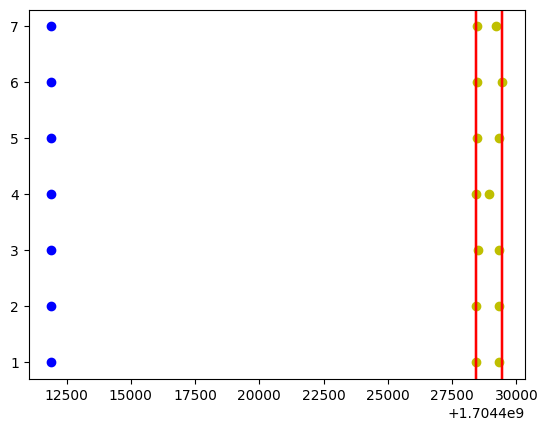

In [27]:
import matplotlib.pyplot as plt
print(present_time)
k = 0
for inter_no in sorted(histid.inter_no.unique()):
    k += 1
    df = histid[histid.inter_no==inter_no]
    M = df.start_unix.max()
    m = df.start_unix.min()
    print(inter_no)
    print(M - m)
    plt.scatter([M, m], [k] * 2, c='y')
    plt.scatter([present_time], [k], c='b')
    plt.axvline(x=histid.start_unix.max(), c='r')
    plt.axvline(x=histid.start_unix.min(), c='r')
    print(m < present_time, present_time < M)

In [26]:
# for m in range(100, 200):
#     histid = preprocess(m)